In [21]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalAveragePooling2D
import numpy as np
from keras import Model
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
import pandas as pd
import generator
import pickle as pkl

特征提取

In [2]:
import feature_extract
import h5py
import numpy as np

In [26]:
feature_extract.get_feature('ResNet50', (224,224))
feature_extract.get_feature('InceptionV3', (299,299))
feature_extract.get_feature('Xception', (299,299))

model ResNet50 begin feature extract
Found 19838 images belonging to 2 classes.
Found 4967 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
model InceptionV3 begin feature extract
Found 19838 images belonging to 2 classes.
Found 4967 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
model Xception begin feature extract
Found 19838 images belonging to 2 classes.
Found 4967 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [27]:
file = h5py.File('InceptionV3_feature.h5','r')

train_feature = np.array(file['train_feature'])
val_feature = np.array(file['val_feature'])
train_label = np.array(file['train_label'])
val_label = np.array(file['val_label'])
test_feature = np.array(file['test_feautre'])

file.close()

file = h5py.File('Xception_feature.h5','r')

train_feature = np.concatenate((train_feature, np.array(file['train_feature'])),axis=1)
val_feature = np.concatenate((val_feature, np.array(file['val_feature'])),axis=1)
test_feature = np.concatenate((test_feature, np.array(file['test_feautre'])),axis=1)
file.close()

file = h5py.File('ResNet50_feature.h5','r')

train_feature = np.concatenate((train_feature, np.array(file['train_feature'])),axis=1)
val_feature = np.concatenate((val_feature, np.array(file['val_feature'])),axis=1)
test_feature = np.concatenate((test_feature, np.array(file['test_feautre'])),axis=1)
file.close()

In [32]:
model = Sequential()
model.add(Dropout(0.5, input_shape=(train_feature.shape[1],)))
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, to_file='Xception_frame.png')

In [34]:
train_epoch = 11


train_res = model.fit(train_feature, train_label, batch_size=256,
                     epochs=train_epoch, validation_data=(val_feature, val_label),
                     verbose=2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/11
 - 3s - loss: 0.1229 - acc: 0.9556 - val_loss: 0.0348 - val_acc: 0.9914
Epoch 2/11
 - 1s - loss: 0.0329 - acc: 0.9900 - val_loss: 0.0207 - val_acc: 0.9946
Epoch 3/11
 - 1s - loss: 0.0217 - acc: 0.9926 - val_loss: 0.0216 - val_acc: 0.9916
Epoch 4/11
 - 1s - loss: 0.0192 - acc: 0.9941 - val_loss: 0.0138 - val_acc: 0.9952
Epoch 5/11
 - 1s - loss: 0.0153 - acc: 0.9945 - val_loss: 0.0149 - val_acc: 0.9944
Epoch 6/11
 - 1s - loss: 0.0153 - acc: 0.9949 - val_loss: 0.0128 - val_acc: 0.9954
Epoch 7/11
 - 1s - loss: 0.0142 - acc: 0.9950 - val_loss: 0.0126 - val_acc: 0.9956
Epoch 8/11
 - 1s - loss: 0.0119 - acc: 0.9962 - val_loss: 0.0138 - val_acc: 0.9952
Epoch 9/11
 - 1s - loss: 0.0119 - acc: 0.9961 - val_loss: 0.0126 - val_acc: 0.9960
Epoch 10/11
 - 1s - loss: 0.0110 - acc: 0.9964 - val_loss: 0.0164 - val_acc: 0.9942
Epoch 11/11
 - 1s - loss: 0.0107 - acc: 0.9963 - val_loss: 0.0122 - val_acc: 0.9962


In [35]:
def show_res(train_res):
    train_line, = plt.plot(range(1,train_epoch+1), train_res.history['loss'], color='red')
    val_line, = plt.plot(range(1, train_epoch+1), train_res.history['val_loss'], color='green')
    
    plt.legend(handles=[train_line, val_line], labels=['train','val'], loc='best')
    plt.title('InceptionV3_loss')
    plt.show()

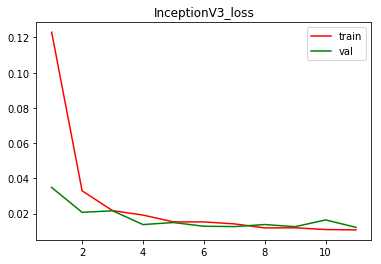

In [36]:
show_res(train_res)

clip的阈值

In [37]:
pred = model.predict(test_feature)
ans = [0]*len(pred)

datagen = image.ImageDataGenerator()
test_gener = datagen.flow_from_directory('./test_data',seed=2018,batch_size=32,shuffle=False)
for i, filename in enumerate(test_gener.filenames):
    index = int(filename[filename.find('/')+1:filename.find('.')])
    ans[index -1] = float(pred[i])

ans = np.clip(ans, 0.005, 0.995)
ans_csv = pd.DataFrame({'id':list(range(1,len(pred)+1)), 'label': ans})
ans_csv.to_csv('pred.csv', index = False)

Found 12500 images belonging to 1 classes.


数据清理带来的提升

In [25]:
#不使用数据清理
#index = []
#使用数据清理
with open('dirty_indexs_final.pkl','rb') as file:
    index = pkl.load(file)

generator.create_dir_for_keras_img_generator(index[0]+index[1])

然后重新训练模型，做预测，提交kaggle看结果

最终结果展示

Found 12500 images belonging to 1 classes.


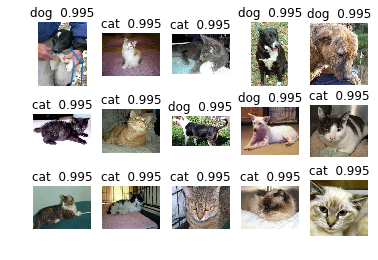

In [56]:
pred = model.predict(test_feature)

cnt = 0
total_img_num = 15

datagen = image.ImageDataGenerator()
test_gener = datagen.flow_from_directory('./test_data',seed=2018,batch_size=32,shuffle=False)
for i, filename in enumerate(test_gener.filenames):
    plt.subplot(3, 5, cnt+1)
    img = plt.imread(filename)
    plt.imshow(img)
    plt.axis('off')
    cata = 'cat' if pred[i]< 0.5 else 'dog'
    confidence = pred[i] if pred[i]>0.5 else 1-pred[i]
    plt.title('%s  %.3f'%(cata, np.clip(confidence,0.1,0.995)))
    cnt += 1
    
    if cnt == 15:
        break

plt.show()